In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
rcParams['figure.dpi'] = 200

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
window = 30

In [4]:
df = pd.read_excel('CSVForDate.xlsx')
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df['Date'] = df['Date'].dt.normalize()
df = df.set_index(['Date'])
df.describe()

,Open,High,Low,Close
count,7351.000000,7349.000000,7349.000000,7368.000000
mean,14308.365312,14400.137951,14194.820989,14266.223039
std,12317.372955,12371.091940,12232.223335,12297.693583
min,966.310000,966.310000,947.140000,956.110000
25%,3620.910000,3651.790000,3578.290000,3603.892500
50%,10083.530000,10191.970000,9911.320000,9978.700000
75%,20837.960000,20917.570000,20652.690000,20736.657500
max,52400.030000,52516.760000,51886.460000,52154.130000


In [5]:
upsampled = df.resample('D')
interpolated = upsampled.interpolate(method='time')
df = interpolated
df.describe()

,Open,High,Low,Close
count,11101.000000,11101.000000,11101.000000,11101.000000
mean,14039.065817,14126.921993,13923.548326,14023.449013
std,12313.259044,12367.318534,12225.167543,12294.030949
min,966.310000,966.310000,947.140000,956.110000
25%,3535.240000,3566.080000,3499.830000,3535.520000
50%,9270.780000,9382.813333,9125.650000,9283.160000
75%,20529.740000,20645.940000,20414.773333,20526.410000
max,52400.030000,52516.760000,51886.460000,52154.130000


In [6]:
df = df.dropna()
del(df['Open'])
del(df['High'])
del(df['Low'])

Text(0.5, 1.0, 'Closing Price of SENSEX from Jan 2, 1991 to May 24, 2021')

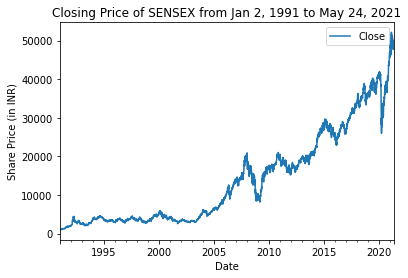

In [7]:
df.plot()
plt.ylabel("Share Price (in INR)")
plt.title("Closing Price of SENSEX from Jan 2, 1991 to May 24, 2021")

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, label, window=30):
    move_avg = timeseries.rolling(window=window).mean()
    move_std = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(move_avg, color='red', label='Rolling Mean')
    std = plt.plot(move_std, color='black', label='Rolling Std')

    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation (Window = %s)" % window)
    plt.xlabel("Time")
    plt.ylabel(label)
    plt.show(block=False)
    
    print("Results of Dickey-Fuller Test for Close")
    dftest = adfuller(timeseries['Close'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

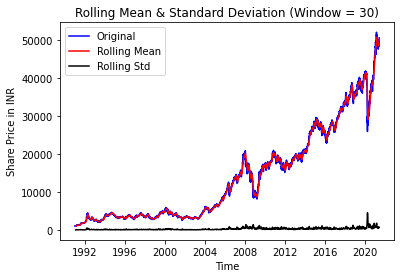

Results of Dickey-Fuller Test for Close
Test Statistic                     1.383006
p-value                            0.997036
#Lags Used                        29.000000
Number of Observations Used    11071.000000
Critical Value (1%)               -3.430941
Critical Value (5%)               -2.861801
Critical Value (10%)              -2.566909
dtype: float64


In [9]:
test_stationarity(df, label="Share Price in INR")

Text(0, 0.5, 'Share Price in Log INR')

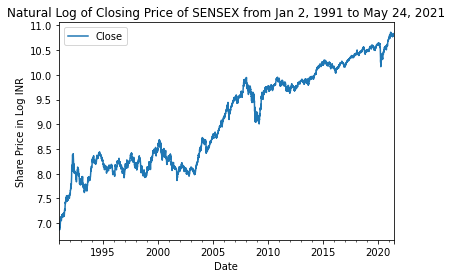

In [10]:
log_df = np.log(df)
log_df.plot()
plt.title("Natural Log of Closing Price of SENSEX from Jan 2, 1991 to May 24, 2021")
plt.ylabel("Share Price in Log INR")

Text(0, 0.5, 'Share Price Difference in Log INR')

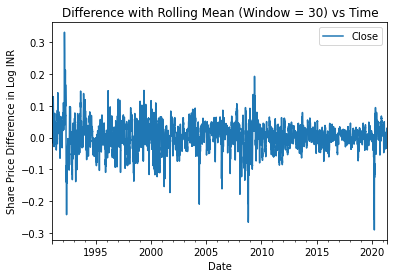

In [11]:
log_minus = log_df - log_df.rolling(window=window).mean()
log_minus.dropna(inplace=True)
log_minus.plot()
plt.title("Difference with Rolling Mean (Window = %s) vs Time" % window)
plt.ylabel("Share Price Difference in Log INR")

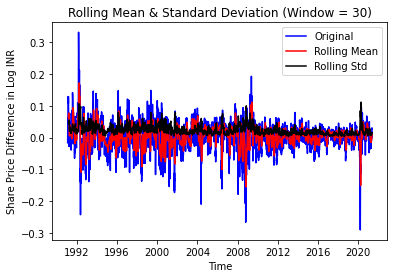

Results of Dickey-Fuller Test for Close
Test Statistic                -1.325556e+01
p-value                        8.602167e-25
#Lags Used                     3.600000e+01
Number of Observations Used    1.103500e+04
Critical Value (1%)           -3.430943e+00
Critical Value (5%)           -2.861802e+00
Critical Value (10%)          -2.566909e+00
dtype: float64


In [12]:
test_stationarity(log_minus, "Share Price Difference in Log INR", window)

Text(0, 0.5, 'Share Price Difference in Log INR')

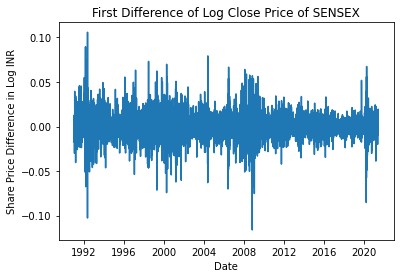

In [13]:
log_shift_df = log_df - log_df.shift()
plt.plot(log_shift_df)
plt.title("First Difference of Log Close Price of SENSEX")
plt.xlabel("Date")
plt.ylabel("Share Price Difference in Log INR")

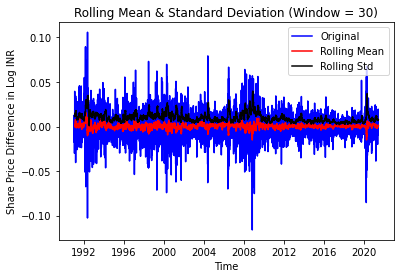

Results of Dickey-Fuller Test for Close
Test Statistic                   -22.017154
p-value                            0.000000
#Lags Used                        19.000000
Number of Observations Used    11080.000000
Critical Value (1%)               -3.430940
Critical Value (5%)               -2.861801
Critical Value (10%)              -2.566909
dtype: float64


In [14]:
log_shift_df.dropna(inplace=True)
test_stationarity(log_shift_df,"Share Price Difference in Log INR", window)

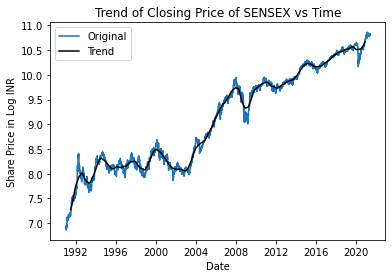

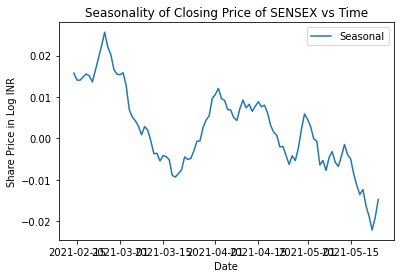

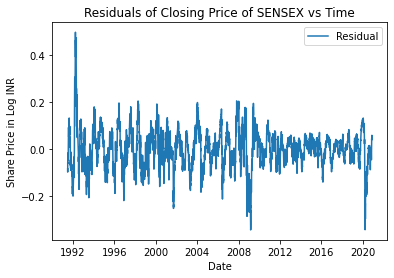

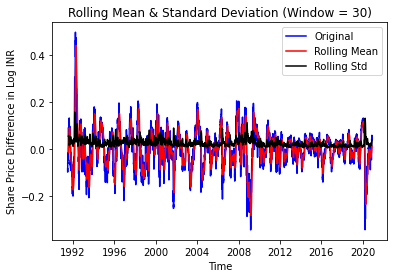

Results of Dickey-Fuller Test for Close
Test Statistic                -9.780252e+00
p-value                        6.763313e-17
#Lags Used                     2.700000e+01
Number of Observations Used    1.070900e+04
Critical Value (1%)           -3.430961e+00
Critical Value (5%)           -2.861810e+00
Critical Value (10%)          -2.566914e+00
dtype: float64


In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(log_df, freq=365)

trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid

plt.figure()
plt.plot(log_df, label="Original")
plt.plot(trend, label="Trend", color="black")
plt.legend()
plt.title("Trend of Closing Price of SENSEX vs Time")
plt.xlabel("Date")
plt.ylabel("Share Price in Log INR")

plt.figure()
plt.plot(seasonal.tail(100), label="Seasonal")
plt.legend()
plt.title("Seasonality of Closing Price of SENSEX vs Time")
plt.xlabel("Date")
plt.ylabel("Share Price in Log INR")

plt.figure()
plt.plot(resid, label="Residual")
plt.legend()
plt.title("Residuals of Closing Price of SENSEX vs Time")
plt.xlabel("Date")
plt.ylabel("Share Price in Log INR")

decomp_log = resid
decomp_log.dropna(inplace=True)
plt.figure()
test_stationarity(decomp_log, "Share Price Difference in Log INR")

Text(0, 0.5, 'ACF')

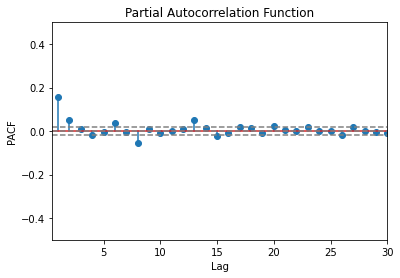

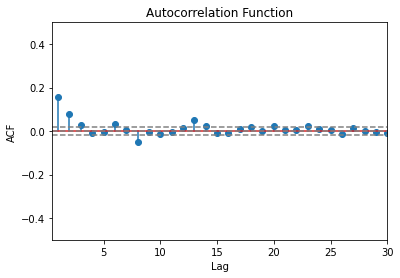

In [16]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(log_shift_df['Close'], nlags=window)
lag_pacf = pacf(log_shift_df['Close'], nlags=window, method='ols')

plt.stem(lag_pacf)
plt.xlim(0.5,30)
plt.ylim(-0.5,0.5)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_shift_df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_shift_df)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel("Lag")
plt.ylabel("PACF")

plt.figure()
plt.stem(lag_acf)
plt.xlim(0.5,30)
plt.ylim(-0.5,0.5)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_shift_df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_shift_df)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.xlabel("Lag")
plt.ylabel("ACF")

In [17]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(log_df, order=(2,1,3))
results = model.fit(disp=-1)

Plotting ARIMA Model


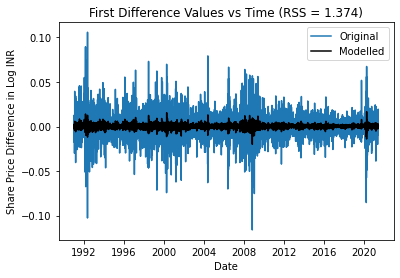

In [18]:
plt.plot(log_shift_df, label="Original")
plt.plot(results.fittedvalues, color='black', label="Modelled")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Share Price Difference in Log INR")
plt.title('First Difference Values vs Time (RSS = %.3f)'%sum(((log_shift_df['Close']-results.fittedvalues))**2))
print('Plotting ARIMA Model')

In [19]:
pred_diff = pd.Series(results.fittedvalues,copy=True)
pred_diff.head()

Date
1991-01-03    0.000353
1991-01-04   -0.002220
1991-01-05    0.000828
1991-01-06    0.001385
1991-01-07    0.002472
Freq: D, dtype: float64

In [20]:
pred_cumsum = pred_diff.cumsum()
pred_cumsum.head()

Date
1991-01-03    0.000353
1991-01-04   -0.001867
1991-01-05   -0.001039
1991-01-06    0.000346
1991-01-07    0.002818
Freq: D, dtype: float64

In [21]:
pred_log = pd.Series(log_df['Close'].iloc[0], index=log_df.index)
pred_log = pred_log.add(pred_cumsum, fill_value=0)
print(pred_log.head())
print(log_df.head())

Date
1991-01-02    6.907015
1991-01-03    6.907368
1991-01-04    6.905148
1991-01-05    6.905976
1991-01-06    6.907361
Freq: D, dtype: float64
               Close
Date                
1991-01-02  6.907015
1991-01-03  6.889948
1991-01-04  6.897154
1991-01-05  6.904309
1991-01-06  6.911414


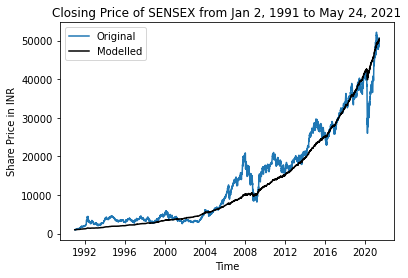

In [22]:
pred = np.exp(pred_log)
plt.plot(df, label="Original")
plt.plot(pred, label="Modelled", color="black")
plt.xlabel("Time")
plt.ylabel("Share Price in INR")
plt.title("Closing Price of SENSEX from Jan 2, 1991 to May 24, 2021")
plt.legend()

In [23]:
days = 31 #Number of forecast days
fcast=results.forecast(steps=days)
temp = np.array([log_df["Close"].iloc[-1]])
forecast_values = np.concatenate((temp, fcast[0]))

In [24]:
from datetime import date, timedelta
start_date = date(2021, 5, 24)
dates = [start_date + timedelta(days=x) for x in range(32)]

In [25]:
new_df = pd.read_excel('CSVForDate (1).xlsx')
new_df['Date'] = pd.to_datetime(new_df['Date'], infer_datetime_format=True)
new_df['Date'] = new_df['Date'].dt.normalize()
new_df = new_df.set_index(['Date'])

new_upsampled = new_df.resample('D')
new_interpolated = new_upsampled.interpolate(method='time')
new_df = new_interpolated

new_df = new_df.dropna()
del(new_df['Open'])
del(new_df['High'])
del(new_df['Low'])

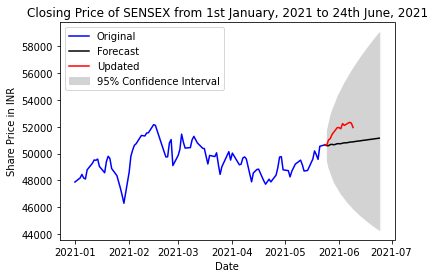

In [26]:
days_since_Jan_1 = 144
plt.plot(df[-days_since_Jan_1:], label="Original", color="blue")
plt.plot(dates, np.exp(forecast_values), label="Forecast", color="black")
plt.plot(dates[:len(new_df)], new_df, label="Updated", color="red")
plt.fill_between(dates[1:], np.exp(fcast[2][:,0]), np.exp(fcast[2][:,1]), color="lightgrey", label="95% Confidence Interval")
plt.title("Closing Price of SENSEX from 1st January, 2021 to 24th June, 2021")
plt.ylabel("Share Price in INR")
plt.xlabel("Date")
plt.legend(loc="upper left")

In [27]:
from datetime import date
df = pd.read_excel('CSVForDate.xlsx')
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df['Date'] = df['Date'].dt.date
df = df.set_index(['Date'])

In [28]:
print("Highest Price as on", df.index[-1].strftime("%d %B, %Y"),"= INR", df['High'].iloc[-1], '\n')
for past in [1,2,5,10,20,30]:
    start = date(2021-past, 5, 24)
    temp_df = df.loc[df.index>start]
    low_date = temp_df['Low'].idxmin()
    low_price = temp_df['Low'].min()
    delta = df.index[-1] - low_date
    print("The lowest price in the last {} year(s) was INR {}.\nThe date for this price was".format(past, low_price), low_date.strftime("%d %B, %Y."))
#     print("The lowest price was INR ", low_price, '.', sep="")
    print("Profit earned per share bought on ", low_date.strftime("%d %B, %Y"), " and sold on ", df.index[-1].strftime("%d %B, %Y"), sep="", end='\nwould have been ')
    print("INR {:.2f}.".format(df['High'].iloc[-1]-low_price))
    num_days = delta.days
    daily_interest = (df['High'].iloc[-1]/low_price)**(1/num_days)
    print("Annual Compound Interest earned over this period would have been", "{:.2f}".format(((daily_interest**365)-1)*100), "%\n")

Highest Price as on 24 May, 2021 = INR 50857.59 

The lowest price in the last 1 year(s) was INR 30512.14.
The date for this price was 26 May, 2020.
Profit earned per share bought on 26 May, 2020 and sold on 24 May, 2021
would have been INR 20345.45.
Annual Compound Interest earned over this period would have been 67.15 %

The lowest price in the last 2 year(s) was INR 25638.9.
The date for this price was 24 March, 2020.
Profit earned per share bought on 24 March, 2020 and sold on 24 May, 2021
would have been INR 25218.69.
Annual Compound Interest earned over this period would have been 79.83 %

The lowest price in the last 5 year(s) was INR 25430.59.
The date for this price was 25 May, 2016.
Profit earned per share bought on 25 May, 2016 and sold on 24 May, 2021
would have been INR 25427.00.
Annual Compound Interest earned over this period would have been 14.87 %

The lowest price in the last 10 year(s) was INR 15135.86.
The date for this price was 20 December, 2011.
Profit earned per